In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import matplotlib
matplotlib.rcParams['figure.figsize'] = [18,4]
import matplotlib.style
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
pd.set_option("display.max_colwidth", None)
from dask import dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count

def launchDask():
    #TODO try, except
    gateway = Gateway()
    options = gateway.cluster_options()
    options.worker_memory=16
    clusters = gateway.list_clusters()
    clusters
    if len(clusters) >0:
        cluster = gateway.connect(clusters[0].name)
        print("using existing connection")#or shut down and start afresh cluster.shutdown(). otherwise I dunno how to apply custom options
        cluster.shutdown()
        cluster = gateway.new_cluster(options)
    else:
        cluster = gateway.new_cluster(options)
    return(cluster)
from dask_gateway import Gateway
from dask.distributed import Client
cluster = launchDask()
from distributed import Client
client = Client(cluster)
client
cluster.adapt(minimum=0, maximum=30)  

In [2]:
from distributed import Client
client = Client(cluster)
client

Client Scheduler: gateway://traefik-daskhub-dask-gateway.daskhub:80/daskhub.c59a543ca11b4f3eb05455d05a2879d8 Dashboard: /services/dask-gateway/clusters/daskhub.c59a543ca11b4f3eb05455d05a2879d8/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
def sibytesto(bytes, to, bsize=10):
    a = {'k' : 3, 'm': 6, 'g' : 9, 't' : 12}
    return(bytes / pow(bsize, a[to]))
#Usage: bytesto(size_in_bytes,'g')

#TiB really.
def bytesto(bytes, to, bsize=2):
    a = {'g' : 30, 't' : 40}
    return(bytes / pow(bsize, a[to]))
#Usage: bytesto(size_in_bytes,'g')


<h2>Prepare Input: Inventory lists and intake catalog pointers, read operations,etc.</h2>

In [5]:
z_inv_list='s3://s3-inventory-collection/cmip6-pds/s3-inventory-config/hive/dt=2021-04-01-00-00/symlink.txt'
zsym = pd.read_csv(z_inv_list, delimiter='\n',dtype='unicode',index_col=False,header=None)
zarr_inventory_dd = dd.read_parquet(zsym[0].tolist(), columns=['key', 'size'], engine='pyarrow',storage_options=dict(anon=True))


In [ ]:
zarr_inventory_dd=zarr_inventory_dd.repartition(npartitions=40)  #zarr_inventory_dd.npartitions
zarr_inventory_dd=zarr_inventory_dd.set_index('key',drop=False)
zarr_inventory_dd['vstore'] = zarr_inventory_dd.apply(
   lambda row: '/'.join([row['key'].split('/v20')[0],'v20'+row['key'].split('v20')[-1].split('/')[0]] ),axis =1).compute() 

In [7]:
#client.persist(zarr_inventory_dd)

In [8]:
zarr_inventory_dd = zarr_inventory_dd.groupby(['vstore'])['size'].sum(split_out=40)
zarr_inventory_dd.compute()
zarr_inventory_dd = zarr_inventory_dd.to_frame()
zarr_inventory_dd = zarr_inventory_dd.reset_index(drop=False)

In [ ]:
zarr_cat = 'https://cmip6-pds.s3.amazonaws.com/compare/pangeo-cmip6-noQC.csv.gz' 
dzarr = pd.read_csv(zarr_cat, dtype='unicode')
ddzarr = dd.from_pandas(dzarr, npartitions=40)
ddzarr['vstore'] = ddzarr.apply(lambda row: (row['zstore'].split('s3://cmip6-pds/')[-1].split('v20')[0]+'v'+row.version), axis = 1).compute()
dzarrtmp = ddzarr.merge(zarr_inventory_dd, on='vstore', how='outer', suffixes=['', '_'], indicator=True)
dzarr = dzarrtmp[dzarrtmp._merge=='both']

ddzarr_groupby =dzarr.groupby(['zstore','vstore','version','source_id','table_id','institution_id','variable_id','member_id','grid_label','experiment_id'])#.sum('size').compute()
series_ddzarr = ddzarr_groupby['size'].sum().compute()
dzarr = series_ddzarr.to_frame()
dzarr = dzarr.sort_values(by=['version'])

dzarr=dzarr.reset_index(drop=False)
dzarr['zstore'] = dzarr.apply(lambda row: (row.vstore.split('s3://cmip6-pds/')[-1].split('v20')[0]), axis = 1)
dzarr['activity_id'] = dzarr.apply(lambda row: row.vstore.split('CMIP6/')[-1].split('/')[0], axis = 1)




In [10]:
#esgf-world catalog
netcdf_cat = 'https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.csv.gz'
dnc = pd.read_csv(netcdf_cat, dtype='unicode')
dnc['key'] = dnc.apply(lambda row: row.path.split('s3://esgf-world/')[-1], axis = 1) #Add key or reuse path as needed--since parquet has the key, for merging later on
#merge dnc and nc_inventory_pd to incorporate size and then remove version duplicates

n_inv_list = 's3://s3-inventory-dest/esgf-world/cmip6-inventory/hive/dt=2021-03-30-00-00/symlink.txt'
nsym = pd.read_csv(n_inv_list, delimiter='\n',dtype='unicode',header=None)
nc_inventory_pd = pd.concat(map(pd.read_parquet, (nsym[0].tolist()) ))
if('is_delete_marker' in nc_inventory_pd): nc_inventory_pd=nc_inventory_pd[nc_inventory_pd['is_delete_marker']==False]    
if('is_latest' in nc_inventory_pd): nc_inventory_pd=nc_inventory_pd[nc_inventory_pd['is_latest']==True]
nc_inventory_pd = nc_inventory_pd[nc_inventory_pd['size'].notna()] 

#merge dnetcdf and nc_inventory_pd to incorporate size and then remove version duplicate
dnctmp = dnc.merge(nc_inventory_pd, on='key', how='outer', suffixes=['', '_'], indicator=True)
dnetcdf = dnctmp[dnctmp._merge=='both']
dnetcdf = dnetcdf[dnetcdf['size'].notna()] 
dnetcdf = dnetcdf.drop(['frequency', 'modeling_realm'], axis=1) #since its NA in esgf-world csv
dnetcdf['zstore'] = dnetcdf.apply(lambda row: row.key.split('s3://esgf-world/')[-1].split('v20')[0], axis = 1)
dnetcdf['vstore'] = dnetcdf.apply(lambda row: row.zstore + str(row.version)+'/', axis = 1)


dnetcdf=dnetcdf.groupby(['zstore','model','version','mip_table','institute','variable','ensemble_member','grid_label','experiment_id'], as_index=False).sum('size') #sum()['size'].sum()
dnetcdf = dnetcdf.sort_values(by=['version'])

print("Total AWS-netcdf in TB",bytesto(dnetcdf['size'].sum(),'t')) #

dnetcdf = dnetcdf.drop_duplicates(subset=["zstore"],keep='last')

dnetcdf = dnetcdf.rename(columns={"mip_table": "table_id","institute":"institution_id","variable":"variable_id"})

dnetcdf['activity_id'] = dnetcdf.apply(lambda row: row.zstore.split('CMIP6/')[-1].split('/')[0], axis = 1)




Total AWS-netcdf in TB 603.5173575302942


<h4>Optional QA</h4>


In [11]:
#VERIFY
searchval = 'CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/v20180701/'
dnetcdf.loc[(dnetcdf['version']=='v20180701') & (dnetcdf['institution_id']=='NOAA-GFDL') & (dnetcdf['experiment_id']=='historical') 
                                                                          & (dnetcdf['table_id'] == 'Amon')
                                                                          & (dnetcdf['variable_id'] == 'rlus')]
                                                                    
#size shows aggregate size as desired 
#old version should not be displayed 'v20180701'

,zstore,model,version,table_id,institution_id,variable_id,ensemble_member,grid_label,experiment_id,size,activity_id
73262,CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/,GFDL-CM4,v20180701,Amon,NOAA-GFDL,rlus,r1i1p1f1,gr1,historical,264327907.0,CMIP


<h2>Compare buckets <h2>


<h5>Data volumes of cmip6-pds and esgf-world as a whole, considering latest DRS versions<h5>

In [12]:
#cdzarr = dzarr.reset_index()

set_L = set(dzarr.zstore.unique())
set_G = set(dnetcdf.zstore.unique())

print('AWS-zarr (number of datasets): ',len(set_L),' AWS-netcdf (number of datasets):', len(set_G),' both (number of datasets):', len(set_G.union(set_L)))
#LATEST DRS VERSIONS 
print("AWS-netcdf in TB",bytesto(dnetcdf['size'].sum(),'t')) #
print("AWS-zarr in TB",bytesto(dzarr['size'].sum(),'t')) #

AWS-zarr (number of datasets):  328091  AWS-netcdf (number of datasets): 241747  both (number of datasets): 495802
AWS-netcdf in TB 559.5743737426756
AWS-zarr in TB 798.1932117615024


<h4> Visual Comparison </h4>

In [13]:

dcpp_nc = len(dnetcdf[dnetcdf.activity_id == 'DCPP'])
dcpp_zarr = len(dzarr[dzarr.activity_id == 'DCPP'])
#We are not accounting for DCPP at this time since the definition of a dataset is yet to be determined here. 
dZR = dzarr[dzarr.activity_id != 'DCPP']
dNC = dnetcdf[dnetcdf.activity_id != 'DCPP']


In [14]:
dzarr.columns 
dzarr[dzarr.activity_id =='DCPP']

,zstore,vstore,version,source_id,table_id,institution_id,variable_id,member_id,grid_label,experiment_id,size,activity_id


In [15]:
m = dZR.merge(dNC, on='zstore', how='outer', suffixes=['', '_'], indicator=True)
dnot_NC = m[m._merge=='left_only']

m = dZR.merge(dNC, on='zstore', how='outer', suffixes=['_', ''], indicator=True)
dnot_ZR = m[m._merge=='right_only']

dZRnNC = dnot_NC[['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore','version', 
       'vstore','size']]

dNCnZR = dnot_ZR[['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore','version', 
       'vstore','size']]


aws_zarr= len(dZR)
aws_nc = len(dNC)
zarr_MissingNC = len(dZRnNC)
nc_MissingZarr = len(dNCnZR)
in_both = aws_zarr - zarr_MissingNC
num_all = aws_zarr+aws_nc-in_both

print('DCPP (netcdf) datasets attribute to', dcpp_nc)
print('DCPP (zarr) datasets attribute to', dcpp_zarr)
print('For all activities other than DCPP, total unique datasets from both:', num_all )
print('S3/zarr has:  ',aws_zarr)
print('S3/netcdf has:',aws_nc)
print('S3/zarr needs:  ',nc_MissingZarr) #guestimate 402TB
print('S3/netcdf needs:', zarr_MissingNC )#guestimate 540TB
print('\n What is common in both buckets:',int(100*(in_both)/num_all),'%') #225TB





DCPP (netcdf) datasets attribute to 69619
DCPP (zarr) datasets attribute to 0
For all activities other than DCPP, total unique datasets from both: 426183
S3/zarr has:   328091
S3/netcdf has: 172128
S3/zarr needs:   98092
S3/netcdf needs: 254055

 What is common in both buckets: 17 %


In [16]:
dZR_size= dZR['size'].sum()
dNC_size = dNC['size'].sum()
dNCnZR_size = dNCnZR['size'].sum()
dZRnNC_size = dZRnNC['size'].sum()

in_both_size = dZR_size-dNC_size
num_all_size = dZR_size+dNC_size -in_both


print('For all activities other than DCPP, size of total unique datasets from both:', num_all_size )
print('S3/zarr has:  ',bytesto(dZR_size,'t'))
print('S3/netcdf has:',bytesto(dNC_size ,'t'))
print('S3/zarr needs:  ',bytesto(dNCnZR_size,'t'),'TB') #guestimate 402TB
print('S3/netcdf needs:', bytesto(dZRnNC_size,'t'),'TB')#guestimate 540TB
print('\n What is common in both buckets:',round(bytesto(in_both_size,'t')),'T')



For all activities other than DCPP, size of total unique datasets from both: 1476171721830092.0
S3/zarr has:   798.1932117615024
S3/netcdf has: 544.3771482173224
S3/zarr needs:   359.7465149165164 TB
S3/netcdf needs: 585.2550630592004 TB

 What is common in both buckets: 254 T


In [17]:
def autolabel(ax,rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=10)

In [18]:
def plot_facet(df_dict,facet='table_id',top_n=8,ymax=300000,ylabel='number',title_add='',units='t'):   
    labels = df_dict.keys()
    stables = set()
    for label in labels:
        stables = stables.union(set(df_dict[label][facet].unique()))    
    tables = sorted(list(stables))
    
    vdfs = {}
    for label in labels:
        df = df_dict[label]
        nvdf = []
        for table in tables:
            if("volume" in ylabel):
                ndf = df[df[facet]==table]['size'].sum()
                ndf = round(bytesto(ndf,units))
            else:
                ndf = df[df[facet]==table].zstore.nunique()
            nvdf += [ndf]
        vdfs[label] = nvdf
    
    names = []
    totals = []
    for item,table in enumerate(tables):
        names += [table]
        tsum = 0
        for label in labels:
            tsum += vdfs[label][item]
        totals += [tsum]

    num_dict = {'name': names,'total':totals}
    for label in labels:
        num_dict[label] = vdfs[label]
    
    df_nums = pd.DataFrame(num_dict)  
    
    df_nums = df_nums.sort_values(by=['total'],ascending=False)
    #df_nums = df_nums.sort_values(by=[list(labels)[1]],ascending=False)

    width = 1.0/(1+len(labels))  # the width of the bars
    
    fig, ax = plt.subplots()

    names = df_nums.name.values[:top_n]
    x = np.arange(len(names)) 
    
    for item,label in enumerate(labels):
        vdf = df_nums[label].values[:top_n]
        rects = ax.bar(x - (len(labels)/2-item-0.5)*width, vdf, width, label=label)
        autolabel(ax,rects)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(f'{ylabel} top {top_n} by {facet}'+title_add)
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylim([0,ymax])
    ax.legend()

    fig.tight_layout()
    #plt.savefig(f'compare-{facet}.png')

    plt.show()

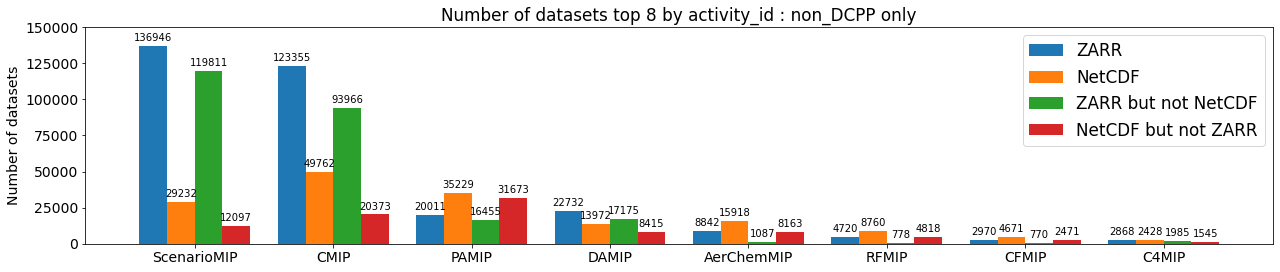

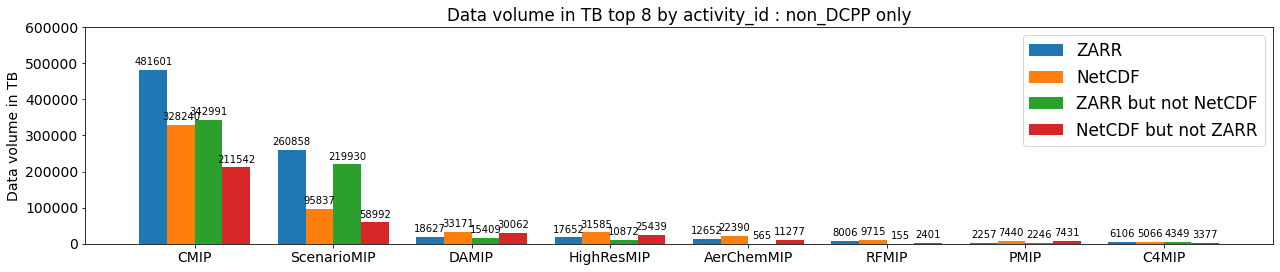

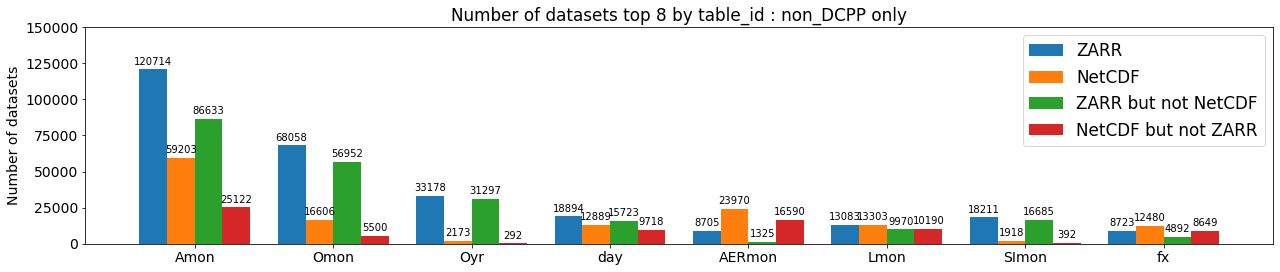

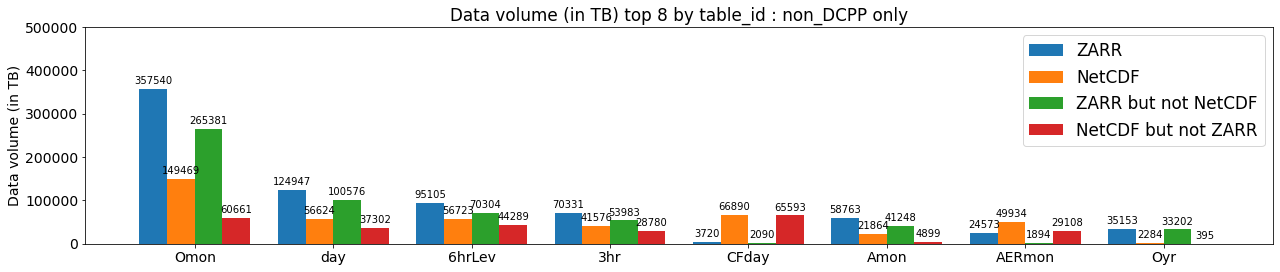

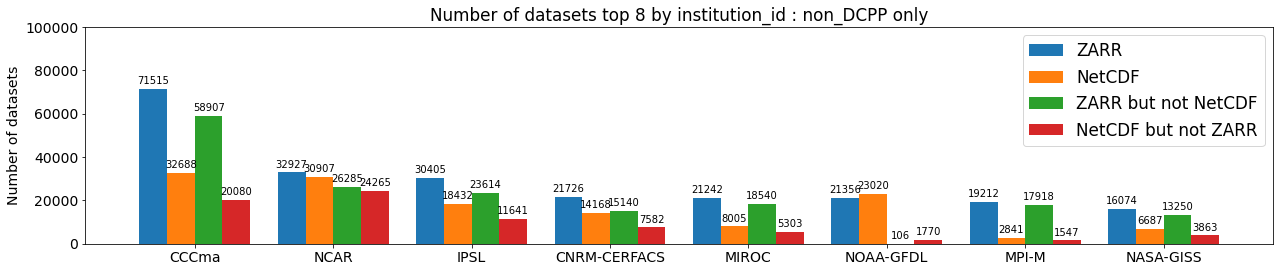

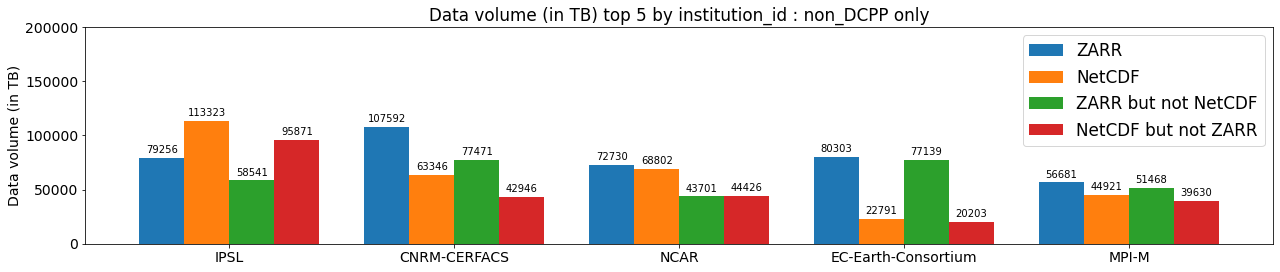

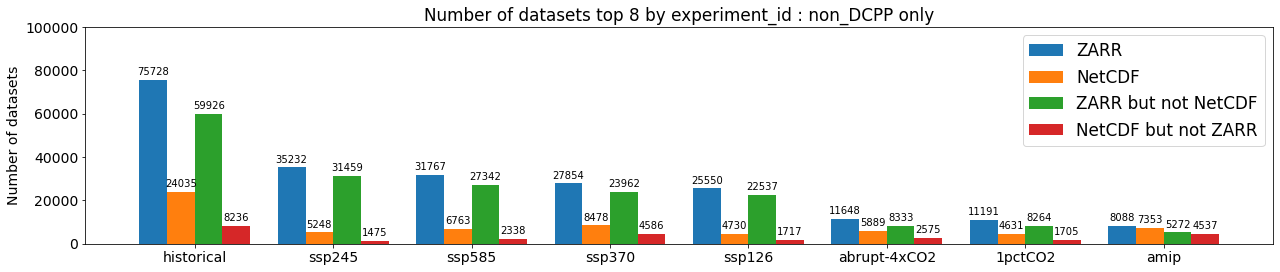

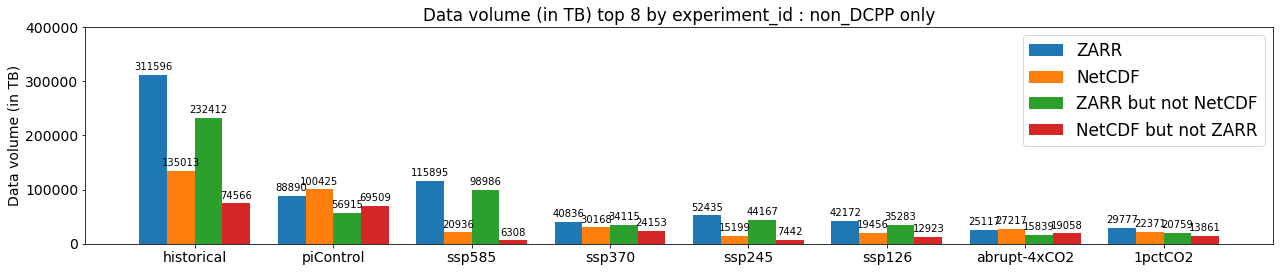

In [19]:
df_dict = {'ZARR':dZR,'NetCDF':dNC,'ZARR but not NetCDF':dZRnNC,'NetCDF but not ZARR':dNCnZR}


df_dict_size = {'ZARR':dZR,'NetCDF':dNC,'ZARR but not NetCDF':dZRnNC,'NetCDF but not ZARR':dNCnZR}



plot_facet(df_dict,facet='activity_id',ymax=150000,ylabel='Number of datasets',title_add = ' : non_DCPP only')
plot_facet(df_dict_size,facet='activity_id',ymax=600000, ylabel='Data volume in TB',title_add = ' : non_DCPP only',units='g')


plot_facet(df_dict,facet='table_id',ymax=150000,ylabel='Number of datasets',title_add = ' : non_DCPP only')
plot_facet(df_dict_size,facet='table_id',ymax=500000,ylabel="Data volume (in TB)",title_add = ' : non_DCPP only',units='g')


plot_facet(df_dict,facet='institution_id',top_n=8,ymax=100000,ylabel='Number of datasets',title_add = ' : non_DCPP only')
plot_facet(df_dict_size,facet='institution_id',top_n=5,ymax=200000,ylabel="Data volume (in TB)",title_add = ' : non_DCPP only',units='g')

plot_facet(df_dict,facet='experiment_id',ymax=100000,ylabel='Number of datasets',title_add = ' : non_DCPP only')
plot_facet(df_dict_size,facet='experiment_id',ymax=400000,ylabel="Data volume (in TB)",title_add = ' : non_DCPP only',units='g')





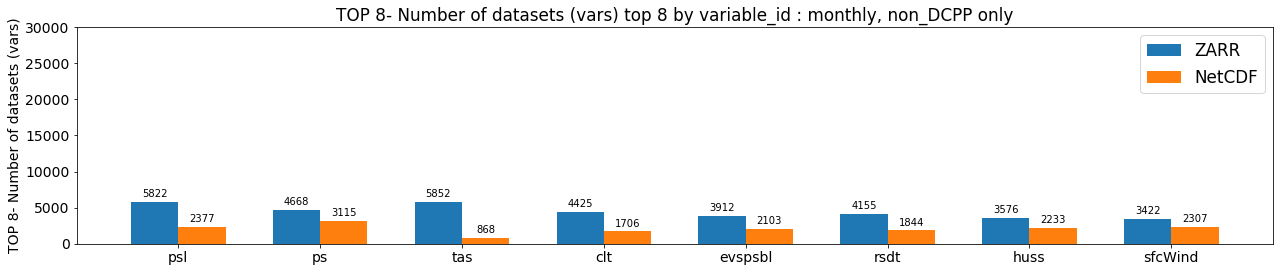

In [20]:

dZRm = dZR[dZR.table_id.str.contains('mon')]
dNCm = dNC[dNC.table_id.str.contains('mon')]
df_dict = {'ZARR':dZRm,'NetCDF':dNCm}
plot_facet(df_dict,facet='variable_id',ymax=30000,ylabel="TOP 8- Number of datasets (vars)",title_add = ' : monthly, non_DCPP only',units='t')
